## Super resolution

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = untar_data(URLs.PETS,dest='')
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageList.from_folder(path_hr)

In [5]:
il

ImageList (7390 items)
Image (3, 218, 300),Image (3, 333, 500),Image (3, 333, 500),Image (3, 441, 500),Image (3, 362, 500)
Path: oxford-iiit-pet/images

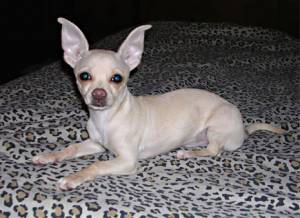

In [6]:
il[0]

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

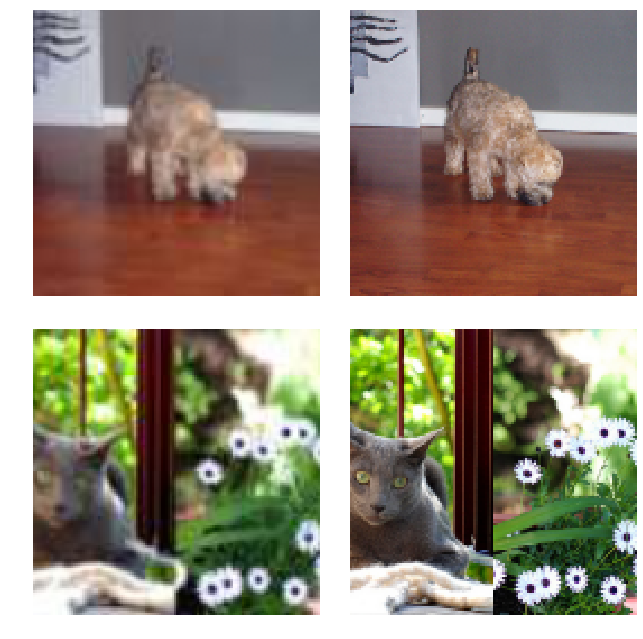

In [12]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [18]:
gram_matrix(t)

tensor([[[0.0965, 0.0751, 0.0714],
         [0.0751, 0.0634, 0.0623],
         [0.0714, 0.0623, 0.0623]],

        [[0.0965, 0.0751, 0.0714],
         [0.0751, 0.0634, 0.0623],
         [0.0714, 0.0623, 0.0623]]])

In [0]:
base_loss = F.l1_loss

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [21]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


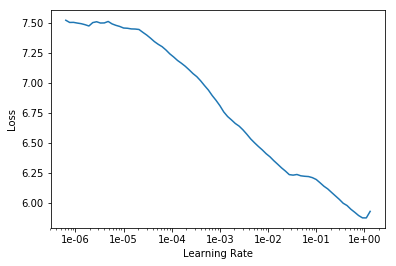

In [23]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [30]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


KeyboardInterrupt: ignored

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.360049,3.140187,0.134617,0.214742,0.277844,0.186940,0.433906,1.018253,0.873886,04:17
1,3.342922,3.129930,0.135262,0.214836,0.277615,0.186491,0.429904,1.014172,0.871650,04:17
2,3.327260,3.123442,0.134678,0.214378,0.277002,0.185904,0.429779,1.012666,0.869035,04:17
3,3.342645,3.117360,0.134898,0.214562,0.277027,0.185532,0.427763,1.011711,0.865868,04:17
4,3.330757,3.116428,0.135784,0.213996,0.276479,0.185650,0.426540,1.010536,0.867441,04:17
5,3.333220,3.105604,0.134177,0.213474,0.275632,0.184619,0.427827,1.007370,0.862506,04:17
6,3.328686,3.097005,0.135160,0.213343,0.275412,0.184702,0.420938,1.003156,0.864295,04:18
7,3.308903,3.093192,0.135351,0.213159,0.275319,0.184071,0.421875,1.004152,0.859265,04:17
8,3.299433,3.087591,0.134284,0.213597,0.274807,0.184194,0.420319,1.001905,0.858485,04:18
9,3.282736,3.074033,0.134001,0.212447,0.273602,0.183147,0.417795,0.997358,0.855684,04:18


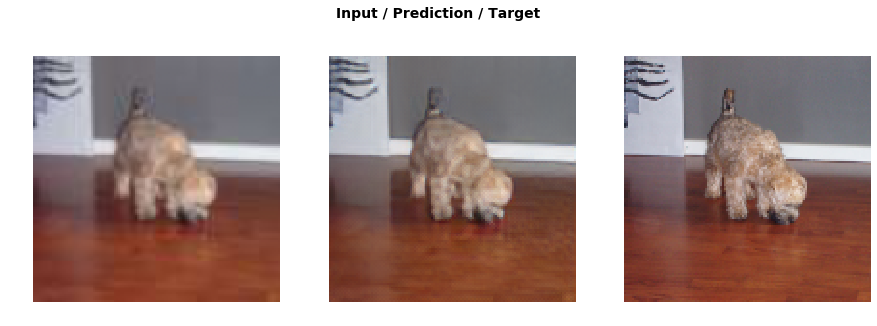

In [28]:
do_fit('1b', slice(1e-5,lr))

In [0]:
data = get_data(12,size*2)

In [30]:
learn.data = data
learn.freeze()
gc.collect()

19639

In [0]:
learn.load('1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.245995,2.218427,0.161340,0.259866,0.296458,0.156717,0.387199,0.588855,0.367992,17:52
1,2.225222,2.185395,0.161591,0.260083,0.294540,0.155021,0.374507,0.577665,0.361987,17:17
2,2.192111,2.162033,0.162722,0.260172,0.293185,0.154379,0.362258,0.569914,0.359404,17:19
3,2.196129,2.147556,0.164372,0.260350,0.291791,0.153170,0.356787,0.565047,0.356038,17:22
4,2.157375,2.127052,0.163298,0.259019,0.289806,0.152109,0.348488,0.560774,0.353557,17:18
5,2.136324,2.115996,0.164416,0.257299,0.288107,0.150605,0.347571,0.556849,0.351149,17:20
6,2.138173,2.106172,0.162505,0.255723,0.285729,0.148104,0.351801,0.555687,0.346624,17:23
7,2.111076,2.093246,0.162590,0.257926,0.286041,0.149009,0.337824,0.552970,0.346886,17:23
8,2.114037,2.090725,0.165104,0.257612,0.286465,0.148411,0.336038,0.551889,0.345208,17:28
9,2.083459,2.065477,0.162133,0.255434,0.282884,0.146439,0.333535,0.543573,0.341478,17:23


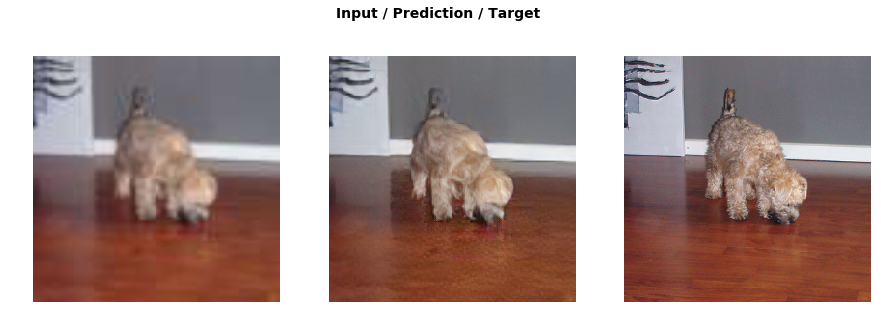

In [32]:
do_fit('2a')

In [0]:
learn.unfreeze()
#learn.load('fully_trained_super_res')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.429295,3.296143,0.141052,0.224367,0.292859,0.198781,0.446564,1.065496,0.927024,04:22
1,3.359806,3.202793,0.137536,0.219507,0.284484,0.191821,0.435072,1.037192,0.897181,04:17
2,3.317337,3.164865,0.135864,0.217357,0.280920,0.188930,0.431321,1.026093,0.884380,04:17
3,3.277851,3.138637,0.135161,0.216094,0.278716,0.187193,0.427253,1.017646,0.876574,04:18
4,3.267833,3.128970,0.134983,0.215930,0.278155,0.186492,0.425662,1.015132,0.872617,04:17
5,3.261011,3.118939,0.134446,0.215182,0.277230,0.185880,0.424600,1.012251,0.869350,04:17
6,3.255097,3.113551,0.134737,0.214865,0.276870,0.185552,0.423085,1.009733,0.868710,04:17
7,3.269255,3.109544,0.134866,0.215035,0.276823,0.185385,0.421732,1.008513,0.867190,04:18
8,3.266972,3.110807,0.134369,0.214657,0.276568,0.185373,0.423338,1.009027,0.867476,04:17
9,3.259712,3.108907,0.134662,0.214867,0.276688,0.185312,0.422010,1.008285,0.867083,04:18


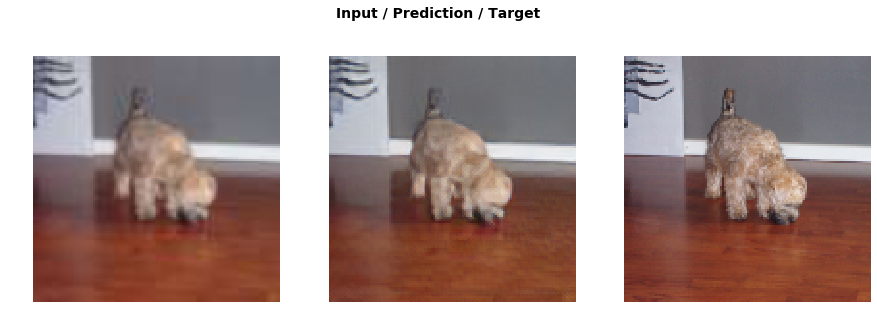

In [40]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [41]:
learn.save('fully_trained_super_res', return_path=True)

PosixPath('oxford-iiit-pet/small-96/models/fully_trained_super_res.pth')

In [0]:
!cp oxford-iiit-pet/small-96/models/fully_trained_super_res.pth /content/drive/My\ Drive/fully_trained_super_res2.pth

## Test

In [0]:
learn = None
gc.collect();

In [44]:
256/320*1024

819.2

In [45]:
256/320*1600

1280.0

In [46]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 8869MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load(Path('/content/drive/My Drive/fully_trained_super_res2'));

In [0]:
learn.data = data_mr

In [51]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('oxford-iiit-pet/small-256/wheaten_terrier_116.jpg')

In [0]:
fn = '/content/drive/My Drive/Dr stone.jpg'

In [57]:
img = open_image(fn); img.shape

torch.Size([3, 960, 640])

In [0]:
p,img_hr,b = learn.predict(img)

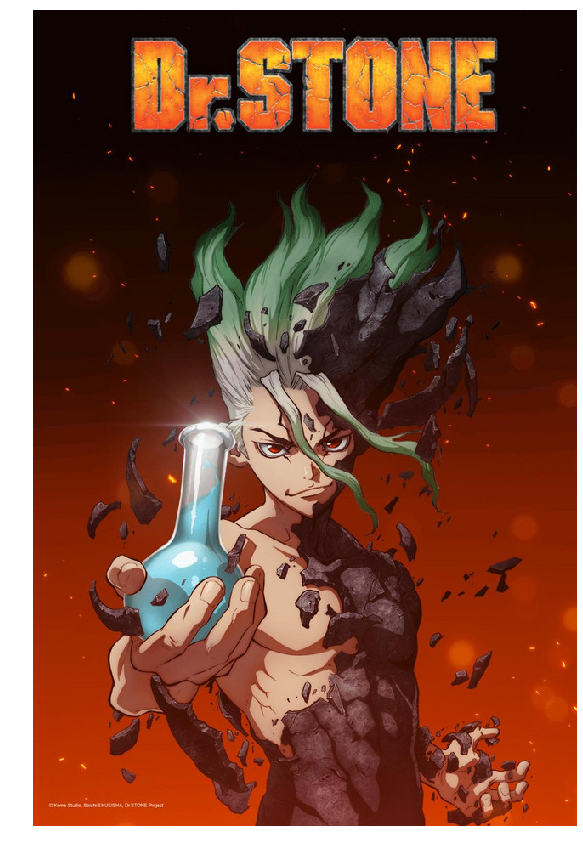

In [59]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


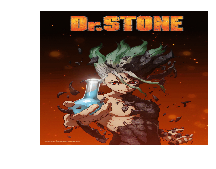

In [61]:
Image(img_hr).show()

In [0]:
output = Image(img_hr)

In [0]:
output.save(
    '/content/drive/My Drive/Dr stone_high.jpg'
)